# Content Based Image Retrieval

This notebook looks into demonstrating Content Based Image Retrieval in a Bag of Visual Words (BoVW) approach. For demonstration purposes, the images used in this notebook is retrieved from [Kaggle](https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset) which is a dataset containing Chest X-Rays images.

Anyway, let's first setup our environment.

In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy import cluster

Let's first take a glance on the training directory files.

In [2]:
train_dir = "/content/data/train"
os.listdir(train_dir)

['17.jpg',
 '14.jpg',
 '15.jpg',
 '09.jpg',
 '02.png',
 '12.jpeg',
 '06.jpeg',
 '07.jpeg',
 '11.jpeg',
 '03.jpeg',
 '13.jpeg',
 '05.png',
 '10.jpg',
 '18.jpg',
 '04.jpeg',
 '19.jpg',
 '20.jpg',
 '01.png',
 '16.jpg',
 '08.jpg']

Since there are plenty of images, we first load them into a list.

In [3]:
train_images = []
for image_data in os.listdir(train_dir):
  image = cv.imread(train_dir + "/" + image_data, cv.IMREAD_GRAYSCALE)
  train_images.append(image)

len(train_images)

20

Done. Before anything, let's also take a glance on our training images.

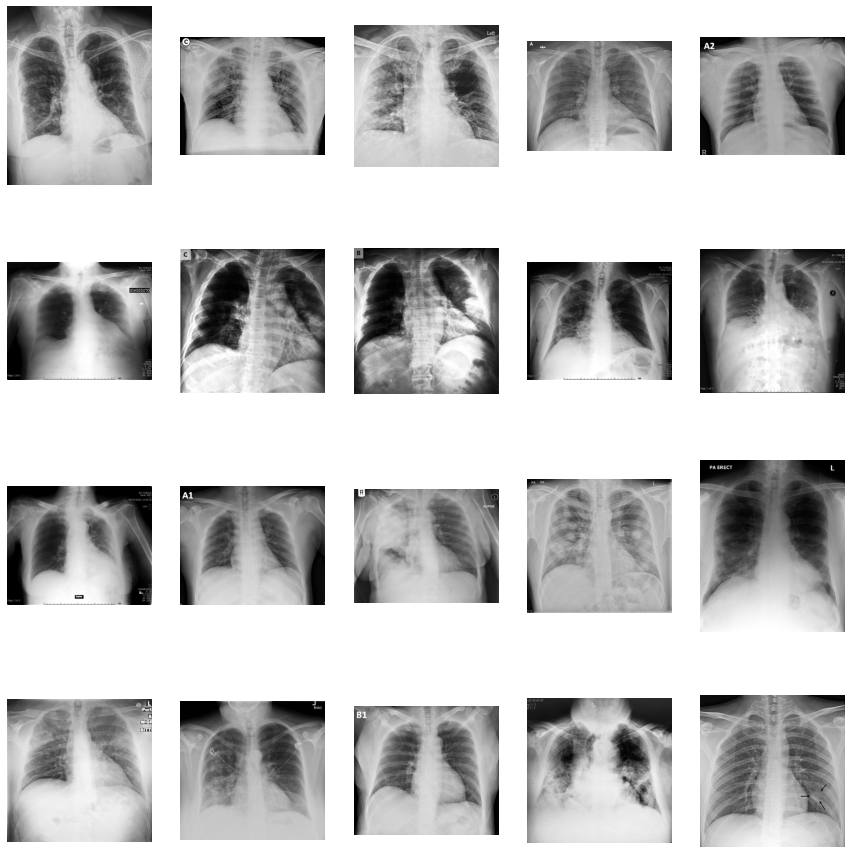

In [4]:
n_images = len(train_images)
plt.figure(figsize=(15, 20))
for index, image in enumerate(train_images):
  plt.subplot(5, n_images / 4, index + 1)
  plt.imshow(image, cmap="gray")
  plt.axis("off")

plt.show()

So the images retrieved are basically Chest X-Rays of individuals with COVID-19 Disease. Next, we want to extract only the descriptors of each and every training images with Scale-Invariant Feature Transform (SIFT).

In [5]:
sift = cv.SIFT_create()
train_descriptors = []
for image in train_images:
  _, descriptors = sift.detectAndCompute(image, None)
  train_descriptors.append(descriptors)

len(train_descriptors)

20

Since there are multiple descriptors, we can't proceed to clustering unless stacking descriptors is done beforehand.

In [6]:
train_descriptors_stack = train_descriptors[0]
for descriptors in train_descriptors[1:]:
  train_descriptors_stack = np.vstack((train_descriptors_stack, descriptors))

train_descriptors_stack = train_descriptors_stack.astype("float32")
train_descriptors_stack

array([[ 10.,   1.,   2., ...,  29.,   2.,  14.],
       [ 34.,  19.,   7., ...,  22.,   4.,   2.],
       [  1.,   0.,   0., ..., 113.,  31.,   0.],
       ...,
       [ 34.,  40.,   0., ...,   0.,   0.,   0.],
       [ 44.,  25.,   3., ...,   2.,   0.,   1.],
       [  5.,   0.,   0., ...,   0.,   0.,   0.]], dtype=float32)

Now we can cluster the train descriptors with k of 5 and iter of 20. Working with clustering can be tricky, for that we want to set the random seed as 42. With a random seed being set, it ensure reproducible results for the demonstration.

In [7]:
centroids, _ = cluster.vq.kmeans(train_descriptors_stack, 5, 20, seed=42)

The next thing is to compute the frequency histogram of train images with the previously obtained train descriptors and centroids.

In [8]:
train_vectors = np.zeros((n_images, len(centroids)), dtype="float32")

for index in range(n_images):
  words, _ = cluster.vq.vq(train_descriptors[index], centroids)
  
  for word in words:
    train_vectors[index][word] += 1

train_vectors

array([[143., 123., 250., 100., 134.],
       [ 62.,  51.,  56.,  86., 116.],
       [334., 363., 424., 283., 354.],
       [ 34.,  32.,  32.,  18.,  34.],
       [ 33.,  25.,  34.,  23.,  47.],
       [ 33.,  53.,  53., 282.,  39.],
       [397., 177., 255., 204., 243.],
       [438., 290., 359., 304., 357.],
       [ 77.,  72.,  80., 223.,  69.],
       [ 72.,  49.,  60., 277.,  28.],
       [ 36.,  57.,  52., 267.,  44.],
       [ 18.,  15.,  20.,  18.,  30.],
       [ 25.,  37.,  55.,  45.,  22.],
       [ 28.,  27.,  50.,  53.,  66.],
       [ 11.,  29.,  30.,  44.,  16.],
       [ 65.,  44.,  58., 111.,  85.],
       [ 39.,  43.,  47.,  59.,  34.],
       [ 51.,  32.,  25.,  23.,  65.],
       [226., 296., 338., 406., 372.],
       [ 95.,  61., 127.,  90., 169.]], dtype=float32)

After computing the train vector, it is obvious that we should normalize it. Since different scale of values are not comparable.

In [9]:
train_vectors = np.array([vector / np.sum(vector) for vector in train_vectors])
train_vectors

array([[0.19066666, 0.164     , 0.33333334, 0.13333334, 0.17866667],
       [0.1671159 , 0.13746631, 0.1509434 , 0.23180594, 0.31266847],
       [0.18998863, 0.20648465, 0.24118316, 0.16097839, 0.20136519],
       [0.22666667, 0.21333334, 0.21333334, 0.12      , 0.22666667],
       [0.2037037 , 0.15432099, 0.20987654, 0.14197531, 0.29012346],
       [0.07173913, 0.11521739, 0.11521739, 0.6130435 , 0.08478261],
       [0.31112853, 0.13871473, 0.19984326, 0.1598746 , 0.19043887],
       [0.2505721 , 0.1659039 , 0.20537758, 0.17391305, 0.20423341],
       [0.14779271, 0.13819578, 0.15355086, 0.42802304, 0.13243762],
       [0.14814815, 0.10082304, 0.12345679, 0.56995887, 0.05761317],
       [0.07894737, 0.125     , 0.11403508, 0.5855263 , 0.09649123],
       [0.17821783, 0.14851485, 0.1980198 , 0.17821783, 0.2970297 ],
       [0.13586956, 0.20108695, 0.29891303, 0.24456522, 0.11956522],
       [0.125     , 0.12053572, 0.22321428, 0.23660715, 0.29464287],
       [0.08461539, 0.22307692, 0.

That is it for the train images. Let's deal with the query image real fast.

In [10]:
query_image = cv.imread("/content/data/query.jpg", cv.IMREAD_GRAYSCALE)
_, query_descriptors = sift.detectAndCompute(query_image, None)

query_descriptors.shape

(542, 128)

We also want to compute the frequency histogram for the query image.

In [11]:
query_vector = np.zeros(len(centroids), dtype="float32")
words, _ = cluster.vq.vq(query_descriptors, centroids)

for word in words:
  query_vector[word] += 1

query_vector

array([ 95.,  61., 127.,  90., 169.], dtype=float32)

Now we should have everything we need to compute the cosine similarity measure of each train image compared to the query image. Let's compute the cosine similarity measures and check it out.

In [12]:
measures = []
for train_vector in train_vectors:
  measures.append(np.dot(train_vector, query_vector) / (np.linalg.norm(train_vector) * np.linalg.norm(query_vector)))

measures

[0.9295884,
 0.9730774,
 0.9510446,
 0.94814235,
 0.9906126,
 0.5943183,
 0.9204612,
 0.95181483,
 0.78024924,
 0.6179103,
 0.61919314,
 0.9934174,
 0.8727423,
 0.98208547,
 0.81522554,
 0.9296984,
 0.90253127,
 0.9479374,
 0.9525744,
 1.0]

Nice. We spot a cosine similarity measure of 1.0 which indicates that a specific train image might just be the same as the query image. Let's visualize to check the specific train image with the best cosine similarity measure.

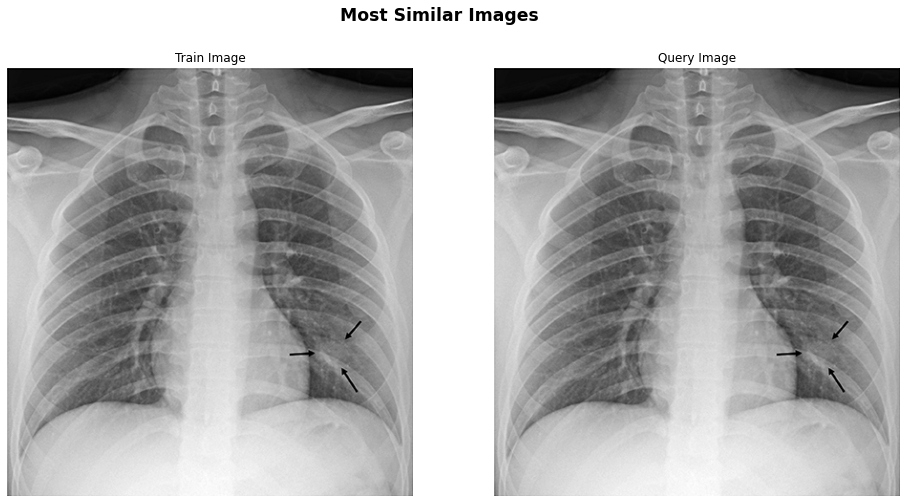

In [13]:
best_measure = measures[np.argmax(measures)]
best_measure_image = train_images[np.argmax(measures)]

plt.figure(figsize=(16, 8))
plt.suptitle("Most Similar Images", 
             fontsize="xx-large", 
             fontweight="semibold")

plt.subplot(1, 2, 1)
plt.title("Train Image")
plt.imshow(best_measure_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Query Image")
plt.imshow(query_image, cmap="gray")
plt.axis("off")

plt.show()

As expected. However, we also have a cosine similarity measure of 0.59 which indicates that a specific train image is quite far off the marks. Let's have a check on that specific train image.

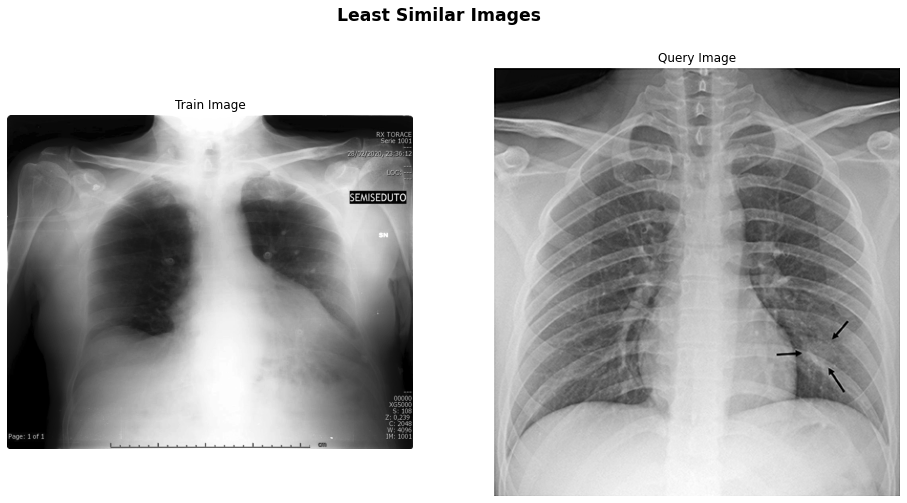

In [14]:
worst_measure = measures[np.argmin(measures)]
worst_measure_image = train_images[np.argmin(measures)]

plt.figure(figsize=(16, 8))
plt.suptitle("Least Similar Images",
             fontsize="xx-large",
             fontweight="semibold")

plt.subplot(1, 2, 1)
plt.title("Train Image")
plt.imshow(worst_measure_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Query Image")
plt.imshow(query_image, cmap="gray")
plt.axis("off")

plt.show()

Well, it is quite obvious that this specific train image is far off the marks. Anyways, we want the overview of cosine similarity measures from other train images included. Not just any overview, we also want to rank the measures.

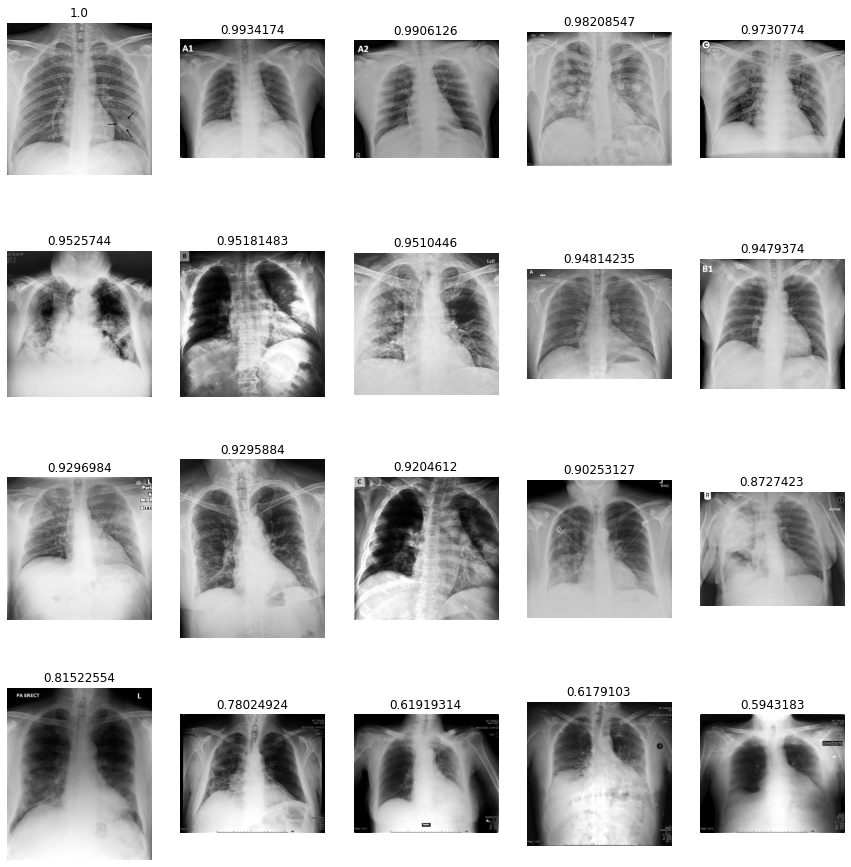

In [15]:
measure_ranks = np.argsort(measures)[::-1]

plt.figure(figsize=(15, 20))
for index, rank in enumerate(measure_ranks):
  plt.subplot(5, n_images / 4, index + 1)
  plt.title(measures[rank])
  plt.imshow(train_images[rank], cmap="gray")
  plt.axis("off")

plt.show()